In [87]:
import numpy as np
import matplotlib.pyplot as plt
from pomegranate.bayesian_network import _learn_structure
import networkx as nx
from tqdm import tqdm

### Variable simulation

Let us take 4 binary variables $v_0, v_1, v_2$ and $v_3$ that can take values from {0,1} in such a way that we know their dependencies.

We make $v_1$ and $v_2$ dependent on $v_0$ and leave $v_3$ out as an independent one.

#### Expected structure = ((), (0,), (0, 1), ())

Meaning of this: if $v_i$ is in the $j^{th}$ tuple, it indicates that $v_j$ is dependent on $v_i$.

To see how well the structure can be learnt from the data we run a random experiment.

We simulate the data 100 times (a randomness is introduced in the data) to learn a structure from each and as we already know the expected structure of the Bayes Net, we can check how many times the learned net is exactly same.

In [88]:
dep = {1:(0,), 0:(), 2:(0,1), 3:()}

In [89]:
def convert_to_tuple(dependency_dict):
    """
    input: dictionary of dependencies (order does not matter)
    -------------------------------------------
    output: tuple of dependencies
    """
    keys = list(dependency_dict.keys())
    keys.sort()
    tup =  [dependency_dict[key] for key in keys]
    return tuple(tup)

def simulation(data_size = 10, noise1 = 0.2, noise2 = 0.3, n = 100, dependency_dict = dep, algorithm = 'exact'):
    """
    Simulate data and learn the structure of the Bayesian Network
    input: data_size, noise1, noise2, n, dependency_dict, algorithm
    data_size: number of samples to generate
    noise1: noise level for the first variable
    noise2: noise level for the second variable
    n: number of simulations
    dependency_dict: dictionary of dependencies
    algorithm: algorithm to learn the structure
    -------------------------------------------
    output: accuracy of the learned structure
    """
    exp_struct = convert_to_tuple(dependency_dict)
    correctness = []
    for i in range(n):
        v0 = np.random.randint(0,2, size = data_size)
        v1 = np.array([v0[i] if np.random.rand() > noise1 else 1-v0[i] for i in range(len(v0))])
        v2 = np.array([v0[i]*v1[i] if np.random.rand() > noise2 else 1-v0[i]*v1[i] for i in range(len(v0))])
        v3 = np.random.randint(0,2, size = data_size)
        X = np.hstack([v0.reshape(-1,1), v1.reshape(-1,1), v2.reshape(-1,1), v3.reshape(-1,1)])
        struct = _learn_structure(X, algorithm = algorithm)
        if struct == exp_struct:
            correctness.append(1)
        else:
            correctness.append(0)
    return 100*np.mean(correctness)

def visualize_BN(dependency_dict = dep):
    """
    input: dictionary of dependencies
    -------------------------------------------
    output: plot of the Bayesian Network
    """
    dependencies = convert_to_tuple(dependency_dict)
    G = nx.DiGraph()
    G.add_nodes_from(range(len(dependencies)))
    for i, dep in enumerate(dependencies):
        for j in dep:
            G.add_edge(j, i)

    independent_nodes = [i for i in G.nodes if G.in_degree(i) == 0 and G.out_degree(i) == 0]
    plt.figure(figsize=(6, 4))
    pos = nx.spring_layout(G, k=1, seed=5)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=15, font_weight='bold', arrowsize=20)
    nx.draw_networkx_nodes(G, pos, nodelist=independent_nodes, node_color='green', node_size=2000, alpha=0.6)    
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)
    plt.margins(0.5)
    plt.title("Dependence Structure Graph")
    plt.show()

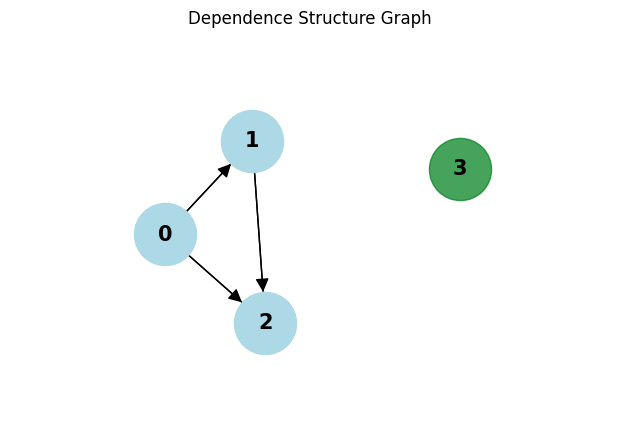

In [90]:
## Visualization of the dependence structure/Bayesian Network

visualize_BN()

In [91]:
data_sizes = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
reps = 100 # number of simulations per data size
accuracy = np.zeros((len(data_sizes), reps))
for d in tqdm(data_sizes):
    for i in range(reps):
        accuracy[data_sizes.index(d), i] = simulation(data_size = d)

100%|██████████| 10/10 [05:32<00:00, 33.30s/it]


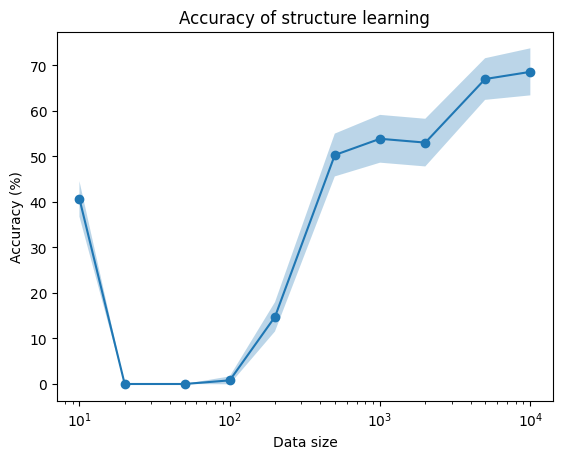

In [92]:
plt.plot(data_sizes, np.mean(accuracy, axis=1), marker = 'o')
plt.fill_between(data_sizes, np.mean(accuracy, axis=1) - np.std(accuracy, axis=1), np.mean(accuracy, axis=1) + np.std(accuracy, axis=1), alpha = 0.3)
plt.xscale('log')
plt.xlabel('Data size')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of structure learning')
plt.show()

 The experiment shows that the accuracy of learning increases with the increase in number of data points.